# **A Simplified NeRF**

This notebook implements a simplified NeRF (Neural Radiance Fields) model using PyTorch.

## Steps:
1. Install and import necessary libraries, and check device
2. Define dataset class
3. Define NeRF model **(your implementation goes here)**
4. Set hyperparameters and train NeRF model
5. Visualize training results
6. Serialize and render


In [34]:
!pip install imageio

## Import necessary libraries

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio

from tqdm import tqdm

device = torch.device("cuda")
print("Current device:", device)

torch.set_default_dtype(torch.float32)

Current device: cuda


## Define Dataset Class

In [36]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NeRFDataset(Dataset):
    """
    NeRF data loading.
    """
    def __init__(self, data_path, device='cuda'):
        data = np.load(data_path)

        self.images = torch.from_numpy(data['images'].astype(np.float32))[..., :3].to(device)   # Shape: [N, H, W, 3]
        self.poses = torch.from_numpy(data['poses'].astype(np.float32)).to(device)              # Shape: [N, 4, 4]
        self.focal = torch.tensor(data['focal'], dtype=torch.float32, device=device)            # Scalar focal length

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx], self.poses[idx], self.focal

## Define NeRF Model

In [37]:
class NeRFNetwork(torch.nn.Module):
    """
    NeRF Model: A Multi-Layer Perceptron (MLP) with integrated ray generation,
    volumetric rendering, and training functionality.
    """
    def __init__(self, hidden_dim=64, n_freqs=6):
        super(NeRFNetwork, self).__init__()
        self.n_freqs = n_freqs  # Positional encoding frequencies
        in_channels = 3 + 3 * 2 * n_freqs  # Input: 3D position + encoded features
        self.layer1 = torch.nn.Linear(in_channels, hidden_dim)
        self.layer2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = torch.nn.Linear(hidden_dim, 4)  # Output: [R, G, B, sigma]

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.output_layer(x)

    def generate_rays(self, H, W, focal, cam2world):
        # get ray origin and dir from cam
        i, j = torch.meshgrid(
            torch.linspace(0, W-1, W, device=device),
            torch.linspace(0, H-1, H, device=device),
            indexing='xy'
        )
        dirs = torch.stack([(i - W * 0.5) / focal, -(j - H * 0.5) / focal, -torch.ones_like(i)], dim=-1)
        rays_d = torch.einsum('ij,hwj->hwi', cam2world[:3, :3], dirs)
        rays_o = cam2world[:3, -1].expand_as(rays_d)
        return rays_o, rays_d

    def positional_encoding(self, x, n_freqs=6):
        """
        Apply positional encoding to input coordinates. The final dimension should be 3 + 3 * 2 * n_freqs.
        IMPORTANT: When passing `x` into a function, always use PyTorch operations
        to ensure compatibility with autograd.

        In this function, you are tasked to work on the following 2 steps:
        (1) Apply `n_freqs` frequency transformations using PyTorch sine and cosine functions.
        (2) Concatenate all encoded features into a single pytorch tensor.
        """
        # Include the original input `x` as part of the encoding.
        encodings = [x]

        # your implementation starts

        for i in range(n_freqs):
            encodings.append(torch.sin(2**i * x))
            encodings.append(torch.cos(2**i * x))

        encoded_pos = torch.cat(encodings, dim=-1)

        # your implementation ends

        # Return the encoded position
        return encoded_pos

    # volume rendering
    def vol_render(self, rays_o, rays_d, near, far, N_samples):
        """
        Render rays via volume rendering.
        IMPORTANT: You should use pytorch functions to implement this.

        In this function, you are tasked to work on the following 4 steps:
        (1) Extract density (`sigma`) and color (`rgb`) from the network output.
        (2) Apply a sigmoid activation to `rgb` to constrain it within [0,1], and use ReLU on `sigma` to ensure non-negative values.
        (3) Compute distances between adjacent depth samples and apply volume rendering equations.
        (4) Compute final pixel color (`rgb_map`) by summing along the ray.

        Hint: you may want to use [pytorch cumulative product](https://pytorch.org/docs/stable/generated/torch.cumprod.html)

        Recommendation: Since there are many tensor operations in this function,
        **record and print the shape of each variable** while implementing,
        and verify that they match expectations. This will help debug shape mismatches
        and ensure correct broadcasting.
        """
         # Partition [near, far] into N evenly-spaced bins (N+1 borders).
        z_vals = torch.linspace(near, far, N_samples + 1, device=device)
        z_vals = z_vals.expand(*rays_o.shape[:-1], N_samples + 1)
        z_vals = 0.5 * (z_vals[..., :-1] + z_vals[..., 1:])
        # Draw one sample uniformly at random from within each bin.
        z_vals += torch.rand_like(z_vals) * ((far - near) / N_samples)
        # Compute 3D positions of sampled points along the rays (ray_o + ray_d * z_vals) and apply `positional_encoding`.
        points = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]  # (H, W, N_samples, 3)
        # Pass the encoded features through the network to obtain raw NeRF outputs.
        raw = self.forward(self.positional_encoding(points.reshape(-1, 3), self.n_freqs)).reshape(*points.shape[:-1], 4) # first three is rgb, last is density

        # your implementation starts

        color = torch.sigmoid(raw[..., :3])
        sigma = torch.relu(raw[..., 3])

        dist = z_vals[..., 1:] - z_vals[..., :-1]
        dist = torch.cat([dist, 1e10 * torch.ones_like(dist[..., :1])], dim=-1)
        coef = torch.exp(-sigma * dist)
        tran = torch.cumprod(torch.cat([torch.ones_like(coef[..., :1]), coef[..., :-1]], dim=-1), dim=-1)

        rgb_map = torch.sum((tran * (1 - torch.exp(-sigma * dist)))[..., None] * color, dim=-2)

        # your implementation ends

        # Return the predicted image
        return rgb_map


    def train_step(self, pose_mat, target_img, focal, optimizer, H, W, near=2.0, far=6.0, n_samples=64):
        """
        Performs one training step.

        In this function, you are tasked to work on the following 4 steps:
        (1) Generate ray origins (`rays_o`) and directions (`rays_d`) from camera parameters (post_mat and focal). Note that we have implemented this for you.
        (2) Render the scene by performing volume rendering (the above function you just implemented) along the rays.
        (3) Compute the mean squared error (MSE) loss between the rendered image and the ground truth (`target_img`).
        (4) Perform backpropagation and update model weights using the optimizer.
        """
        # your implementation starts

        rays_o, rays_d = self.generate_rays(H, W, focal, pose_mat)
        image = self.vol_render(rays_o, rays_d, near, far, n_samples)
        loss = torch.nn.functional.mse_loss(image, target_img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # your implementation ends

        # Return the loss
        return loss.item()

    def test_step(self, test_pose, test_image, focal, H, W, near=2.0, far=6.0, n_samples=64):
        """
        Performs a test step to evaluate the model.

        In this function, you are tasked to work on the following 4 steps:
        (1) Generate test rays (`rays_o`, `rays_d`) from the test camera pose. Note that we have implemented this for you.
        (2) Perform volume rendering to obtain the predicted image.
        (3) Compute the mean squared error (MSE) loss against the test image.
        (4) Compute the peak signal-to-noise ratio (PSNR) as a quality metric, where PSNR = -10*log_10(MSELoss).
        """
        # your implementation starts

        rays_o, rays_d = self.generate_rays(H, W, focal, test_pose)
        test_rgb_map = self.vol_render(rays_o, rays_d, near, far, n_samples)
        loss = torch.nn.functional.mse_loss(test_rgb_map, test_image)
        test_psnr = -10 * torch.log10(loss)

        # your implementation ends

        # Return the predicted image and the PSNR
        return test_rgb_map, test_psnr.item()



## Load and Prepare Training Data

In [38]:
# dataset path, change it for different datasets
full_dataset = NeRFDataset("tiny_lego.npz")

# Split dataset: Use first 99 images for training, 100th image for testing
train_dataset = torch.utils.data.Subset(full_dataset, range(99))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_image, test_pose, focal_torch = full_dataset[99]

# Get image dimensions
H, W = test_image.shape[:2]
print("Test image resolution:", test_image.shape)

# Default hyperparameters, feel free to change
n_samples = 64        # Number of samples per ray
num_iters = 10000     # Number of training iterations
learning_rate = 5e-3  # Learning rate
n_freqs = 6           # positional encoding frequency
logging_freq = 1000   # Log output frequency (iterations)

Test image resolution: torch.Size([100, 100, 3])


## Train NeRF Model

In [39]:
from itertools import cycle

# Initialize model and optimizer
model = NeRFNetwork(hidden_dim=64, n_freqs=n_freqs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

psnr_log = []
iter_log = []


print("Starting NeRF Training...")
train_iter = cycle(train_loader)
for i in tqdm(range(num_iters)):  # num_iters=10000
    target_img, pose_mat, focal = next(train_iter)
    loss = model.train_step(pose_mat.squeeze(0), target_img.squeeze(0), focal.squeeze(0), optimizer, H, W)
    # Log training progress
    if (i) % logging_freq == 0:
        _, test_psnr = model.test_step(test_pose, test_image, focal_torch, H, W)
        psnr_log.append(test_psnr)
        iter_log.append(i)
        print(f"Iteration {i}: Training Loss={loss:.4f}, Test PSNR={test_psnr:.2f}")
print("Training Completed!")


Starting NeRF Training...


  0%|          | 7/10000 [00:00<02:29, 66.88it/s]

Iteration 0: Training Loss=0.1756, Test PSNR=7.50


 10%|█         | 1015/10000 [00:12<01:59, 75.42it/s]

Iteration 1000: Training Loss=0.0093, Test PSNR=20.18


 20%|██        | 2016/10000 [00:25<01:35, 83.93it/s]

Iteration 2000: Training Loss=0.0064, Test PSNR=21.37


 30%|███       | 3016/10000 [00:37<01:25, 81.54it/s]

Iteration 3000: Training Loss=0.0044, Test PSNR=21.37


 40%|████      | 4012/10000 [00:50<01:17, 77.62it/s]

Iteration 4000: Training Loss=0.0041, Test PSNR=20.60


 50%|█████     | 5010/10000 [01:03<01:05, 76.55it/s]

Iteration 5000: Training Loss=0.0057, Test PSNR=22.15


 60%|██████    | 6010/10000 [01:15<00:51, 76.80it/s]

Iteration 6000: Training Loss=0.0029, Test PSNR=21.90


 70%|███████   | 7011/10000 [01:28<00:38, 78.06it/s]

Iteration 7000: Training Loss=0.0063, Test PSNR=22.04


 80%|████████  | 8012/10000 [01:41<00:25, 77.68it/s]

Iteration 8000: Training Loss=0.0039, Test PSNR=23.08


 90%|█████████ | 9014/10000 [01:54<00:12, 76.92it/s]

Iteration 9000: Training Loss=0.0047, Test PSNR=23.36


100%|██████████| 10000/10000 [02:06<00:00, 78.93it/s]

Training Completed!


## Visualize the Rendered Test Image and PSNR

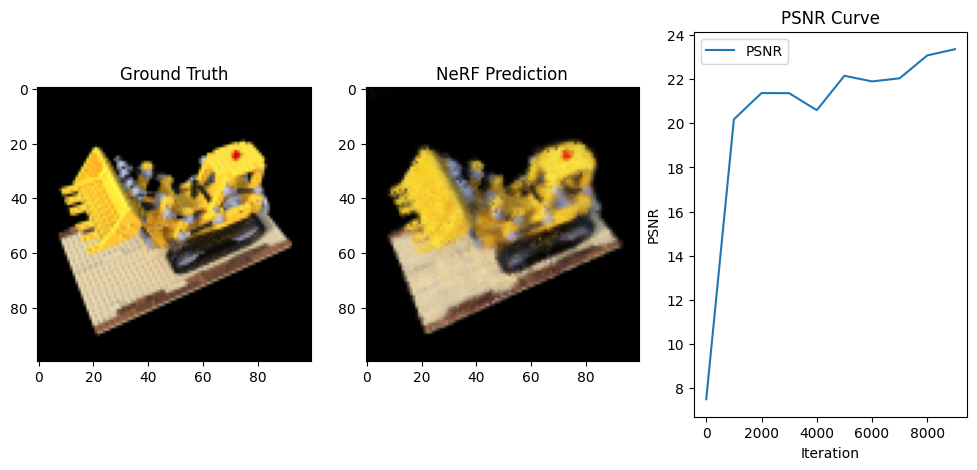

In [42]:
with torch.no_grad():
    pred_rgb, test_psnr = model.test_step(test_pose, test_image, focal_torch, H, W)


# Convert tensors to NumPy arrays for visualization
pred_rgb_np = pred_rgb.cpu().numpy()
test_img_np = test_image.cpu().numpy()

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(test_img_np)
plt.title("Ground Truth")

plt.subplot(1,3,2)
plt.imshow(pred_rgb_np)
plt.title("NeRF Prediction")

plt.subplot(1,3,3)
plt.plot(iter_log, psnr_log, label='PSNR')
plt.xlabel("Iteration")
plt.ylabel("PSNR")
plt.title("PSNR Curve")
plt.legend()
plt.show()


## Serialize Model

In [44]:
# You may need to modify this function if you change the network structure too aggressively.
import re

def dump_data(t):
    return t.detach().cpu().numpy()

def fmt_float(x):
    s = f"{x:.2f}"
    s = re.sub(r"\b0\.", ".", s)
    return s

def print_vec4(v):
    vals = ",".join(fmt_float(x) for x in v)
    return f"vec4({vals})"

def print_mat4(m):
    mT = m.T
    vals = []
    for r in range(4):
        for c in range(4):
            vals.append(fmt_float(mT[r,c]))
    return f"mat4({','.join(vals)})"

def positional_encoding_glsl(n_freqs=6, varname="p"):
    lines = []

    encode_vals = []
    # 0) p.x, p.y, p.z
    encode_vals.append(f"{varname}.x")
    encode_vals.append(f"{varname}.y")
    encode_vals.append(f"{varname}.z")
    # 1) sin/cos
    import math
    for i in range(n_freqs):
        freq = 2**i
        # sin(freq * p.x), sin(freq * p.y), sin(freq * p.z)
        encode_vals.append(f"sin({fmt_float(freq)}*{varname}.x)")
        encode_vals.append(f"sin({fmt_float(freq)}*{varname}.y)")
        encode_vals.append(f"sin({fmt_float(freq)}*{varname}.z)")
        # cos(freq * p.x), cos(freq * p.y), cos(freq * p.z)
        encode_vals.append(f"cos({fmt_float(freq)}*{varname}.x)")
        encode_vals.append(f"cos({fmt_float(freq)}*{varname}.y)")
        encode_vals.append(f"cos({fmt_float(freq)}*{varname}.z)")


    num_chunks = (len(encode_vals) + 3)//4
    for c in range(num_chunks):
        start = c*4
        end = start+4
        subset = encode_vals[start:end]
        if len(subset) < 4:
            subset += ["0.0"]*(4 - len(subset))
        line = f"vec4 PE_{c} = vec4({','.join(subset)});"
        lines.append(line)

    return lines, num_chunks

def serialize_nerf_network(model, n_freqs=6, varname="f"):
    lines = []


    pe_code, pe_chunks = positional_encoding_glsl(n_freqs=n_freqs, varname="p")
    lines.extend(pe_code)
    lines.append("")

    input_dim = 4*pe_chunks


    layer1 = model.layer1
    w1 = dump_data(layer1.weight)  # shape: [hidden_dim, input_dim]
    b1 = dump_data(layer1.bias)    # shape: [hidden_dim]
    hidden_dim = w1.shape[0]


    chunk0 = (hidden_dim+3)//4

    for i in range(chunk0):
        r0 = i*4
        r1 = min(r0+4, hidden_dim)
        size = r1-r0

        w_sub = w1[r0:r1, :]  # shape=[size, input_dim]
        b_sub = b1[r0:r1]
        if size<4:
            pad = 4-size
            w_sub = np.pad(w_sub, ((0,pad),(0,0)), mode='constant')
            b_sub = np.pad(b_sub, (0,pad), mode='constant')

        line = f"vec4 {varname}0_{i} = relu(\n    "
        sum_terms = []
        for j in range(pe_chunks):
            c0 = j*4
            c1 = c0+4
            block = w_sub[:, c0:c1]  # shape=[4, 4]
            col_size = block.shape[1]
            if col_size<4:
                block = np.pad(block, ((0,0),(0,4-col_size)), mode='constant')
            m_str = print_mat4(block)
            sum_terms.append(f"{m_str} * PE_{j}")
        bias_str = print_vec4(b_sub)
        line += " +\n    ".join(sum_terms)
        line += f" + {bias_str});"
        lines.append(line)

    lines.append("")

    # layer2
    layer2 = model.layer2
    w2 = dump_data(layer2.weight)  # [hidden_dim, hidden_dim]
    b2 = dump_data(layer2.bias)
    chunk1 = (layer2.out_features+3)//4

    hidden_dim2 = w2.shape[0]
    chunk1 = (hidden_dim2 +3)//4

    for i in range(chunk1):
        r0 = i*4
        r1 = min(r0+4, hidden_dim2)
        size = r1-r0

        w_sub = w2[r0:r1, :]  # shape=[size, hidden_dim]
        b_sub = b2[r0:r1]
        if size<4:
            pad = 4-size
            w_sub = np.pad(w_sub, ((0,pad),(0,0)), mode='constant')
            b_sub = np.pad(b_sub, (0,pad), mode='constant')

        # "vec4 f1_i = relu( sum_j mat4(...) * f0_j + bias );"
        line = f"vec4 {varname}1_{i} = relu(\n    "
        sum_terms = []
        for j in range(chunk0):
            c0 = j*4
            c1 = c0+4
            block = w_sub[:, c0:c1]
            if block.shape[1]<4:
                block = np.pad(block, ((0,0),(0,4-block.shape[1])), mode='constant')
            m_str = print_mat4(block)
            sum_terms.append(f"{m_str} * {varname}0_{j}")
        bias_str = print_vec4(b_sub)
        line += " +\n    ".join(sum_terms)
        line += f" + {bias_str});"
        lines.append(line)

    lines.append("")

    # output_layer( shape=[4, hidden_dim2] )
    outlayer = model.output_layer
    w3 = dump_data(outlayer.weight) # shape=[4, hidden_dim2]
    b3 = dump_data(outlayer.bias)   # shape=[4]


    out_lines = []
    for o in range(4):
        wrow = w3[o, :]  # [hidden_dim2]
        expr = f"float out{o} = "
        sum_terms = []
        for j in range(chunk1):
            c0 = j*4
            c1 = c0+4
            subvec = wrow[c0:c1]
            if len(subvec)<4:
                subvec = np.pad(subvec, (0,4-len(subvec)), mode='constant')
            v4 = print_vec4(subvec)
            sum_terms.append(f"dot({varname}1_{j}, {v4})")
        expr += " + ".join(sum_terms)
        expr += f" + {fmt_float(b3[o])};"
        out_lines.append(expr)

    out_lines.append("return vec4(out0, out1, out2, out3);")

    lines.extend(out_lines)

    glsl_code = (
        "vec4 queryNetwork(vec3 p){\n"
    )
    body_block = "\n".join("    " + l for l in lines)

    glsl_code += body_block
    glsl_code += "\n}\n"

    return glsl_code

code = serialize_nerf_network(model, n_freqs=n_freqs)
filename = "serialized_model.txt"
with open(filename, "w", encoding="utf-8") as f:
    f.write(code)
print("Serialization done, results stored in " + filename)

Serialization done, results stored in serialized_model.txt


## Acknowledgements

This implementation is based on the following works:  

- [Tiny NeRF (Colab)](https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb).  
- [TinyNeRF](https://github.com/volunt4s/TinyNeRF-pytorch).  

The dataset comes from the [Nerf Synthetic Dataset](https://www.kaggle.com/datasets/nguyenhung1903/nerf-synthetic-dataset)